# RASP Diabetes Rates

Diabetes rates from CHIS surveys for 2015, 2016 and 2017, segmented by race, age, sex and poverty status


In [2]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from publicdata.chis import *

%matplotlib inline
sns.set_context('notebook')
idx = pd.IndexSlice # Convenience redefinition. 


In [3]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

In [3]:
def recode(df):
    """ Recode to a simpler group of races.  For a lot of health outcomes, the major divisions are
    * White + Asian ( whasian )
    * Black + Latino Afrotino
    * Others
    """
    
    from pandas.api.types import CategoricalDtype
    
    df['race_recode'] = df.racedf_p1
    df.replace({'race_recode':{
        'NON-LATINO WHITE':'nhwhite',
        'NON-LATINO ASIAN':'asian',
        'NON-LATINO AMERICAN INDIAN/ALASKAN NATIVE': 'other',
        'NON-LATINO AFR. AMER.': 'black',
        'LATINO': 'hisp',
        'NON-LATINO, TWO+ RACES': 'other',
        'NON-LATINO OTHER, ONE RACE': 'other'
    }}, inplace=True)
    df.race_recode = df.race_recode.astype('category')
    
    df['minority'] = (df['race_recode'] != 'white_asian').astype(int)
    
    
    df['old'] = (df.srage_p1 < '45-49 YEARS').astype(CategoricalDtype(categories=[False, True],ordered=True))
    df.old.cat.rename_categories(['OLD','YOUNG'], inplace=True)

    df['poor'] = (df.povll.isin(('200-299% FPL', '300% FPL AND ABOVE')) )\
        .astype(CategoricalDtype(categories=[True, False],ordered=True))
    df.poor.cat.rename_categories(['NPOV','POV'], inplace=True)

    return df


In [4]:
df17 = pkg.reference('adult_2017').dataframe()
df16 = pkg.reference('adult_2016').dataframe()
df15 = pkg.reference('adult_2015').dataframe()
df14 = pkg.reference('adult_2014').dataframe()
df13 = pkg.reference('adult_2013').dataframe()

# Rename some categories. 2016 and 2015 have "ALASKA" where the others have "ALASKAN", which 
# causes the concat() operation to convert categories to strings
cats_17 = df17.racedf_p1.cat.categories
cat_map = dict(zip(df16.racedf_p1.cat.categories, df17.racedf_p1.cat.categories))

for e in [df13,df14,df15,df16,df17]:
    e.racedf_p1.cat.rename_categories(cat_map, inplace=True)
    
for df, year in zip([df13, df14, df15, df16, df17], range(2013, 2018)):
    df['year'] = year
    
    df = recode(df)

# Poverty, Age and Race


In [5]:

n_years, df1517 = chis_concat([df17,df16,df15], ['diabetes', 'srsex', 'srage_p1', 'racedf_p1', 'race_recode', 'povll', 'minority', 'poor', 'old'])

def age_group_parts(v):
    try:
        y1, y2, _ = v.replace('-',' ').split()
        return y1,y2
    except ValueError:
        # Probably '85+ YEARS'
        return 85, 120



def age_group_to_age(v):
    y1, y2 = age_group_parts(v)
    if y1 == 85:
        return 85
    else:
        return (int(y1)+int(y2))/2

# Convert to census age ranges
census_age_ranges = [
    pd.Interval(18, 24, closed='both'),
    pd.Interval(25, 34, closed='both'),
    pd.Interval(35, 44, closed='both'),
    pd.Interval(45, 54, closed='both'),
    pd.Interval(55, 64, closed='both'),
    pd.Interval(65, 74, closed='both'),
    pd.Interval(75, 85, closed='both') # Actualy range is 75:120, but want a lower mean for prediction
]
    

pov_status_map = {
    "0-99% FPL": 1,
    "100-199% FPL": 0,
    "200-299% FPL":0,
    "300% FPL AND ABOVE": 0
}

dflr = pd.get_dummies(df1517, columns=['race_recode'], prefix='', prefix_sep = '')
dflr['race_recode'] = df1517.race_recode 
dflr['diabetes_bool'] = (dflr.diabetes == 'YES').astype(int)
dflr['group_age_mean'] = dflr.srage_p1.apply(lambda v:age_group_to_age(v)).astype(float)
dflr['group_age_min'] = dflr.srage_p1.apply(lambda v:age_group_parts(v)[0]).astype(int)
dflr['group_age_max'] = dflr.srage_p1.apply(lambda v:age_group_parts(v)[1]).astype(int)

dflr['census_age_group'] = pd.cut(dflr.group_age_mean, pd.IntervalIndex(census_age_ranges))

#dflr['age_group_name'] = dflr.apply(lambda r: '{:02d}-{:03d}'.format(r.group_age_min, r.group_age_max), axis=1)
dflr['age_group'] = dflr.census_age_group.apply(lambda v: '{:02d}-{:03d}'.format(v.left, v.right))

dflr['pov'] = dflr.povll.apply(lambda v: pov_status_map[v])
dflr['is_male'] = (dflr.srsex == 'MALE').astype(int)

dflr.head() 

,index,diabetes,srsex,srage_p1,racedf_p1,povll,minority,poor,old,rakedw0,...,other,race_recode,diabetes_bool,group_age_mean,group_age_min,group_age_max,census_age_group,age_group,pov,is_male
0,0,NO,FEMALE,70-74 YEARS,NON-LATINO WHITE,200-299% FPL,1,NPOV,OLD,12.380612,...,0,nhwhite,0,72.0,70,74,"[65, 74]",65-074,0,0
1,1,NO,MALE,65-69 YEARS,NON-LATINO WHITE,300% FPL AND ABOVE,1,NPOV,OLD,216.417872,...,0,nhwhite,0,67.0,65,69,"[65, 74]",65-074,0,1
2,2,NO,MALE,80-84 YEARS,NON-LATINO WHITE,300% FPL AND ABOVE,1,NPOV,OLD,112.672832,...,0,nhwhite,0,82.0,80,84,"[75, 85]",75-085,0,1
3,3,NO,MALE,60-64 YEARS,NON-LATINO WHITE,100-199% FPL,1,POV,OLD,198.559016,...,0,nhwhite,0,62.0,60,64,"[55, 64]",55-064,0,1
4,4,YES,FEMALE,60-64 YEARS,NON-LATINO WHITE,300% FPL AND ABOVE,1,NPOV,OLD,256.148161,...,0,nhwhite,1,62.0,60,64,"[55, 64]",55-064,0,0


In [6]:
raked_col = [c for c in df.columns if c.startswith('rake')]
index_cols = ['race_recode','is_male', 'age_group', 'pov' ]
value_cols = ['diabetes_bool', 'rec_count']
dflr['rec_count'] = 1

dflr['census_age_group'] = pd.cut(dflr.group_age_mean, pd.IntervalIndex(census_age_ranges))

t = dflr[index_cols+value_cols+raked_col].copy()


# Couldn't figure out the idomatic way to do this. 
t['group_pop'] = t.rakedw0
for c in raked_col:
    t[c] *= t.diabetes_bool

# Now the raked columns are the estimates for the number of people who have diabetes, 
# so we just have to sum up everything
    
t2 = t.groupby(index_cols).sum().reset_index()

t2['estimate'] = t2.rakedw0
t2['repl_mean'] = t2[raked_col[1:]].mean(axis=1)
t2['repl_std'] = t2[raked_col[1:]].std(axis=1)

t2['rse'] = t2['repl_std']/t2.estimate

t2['rate'] = t2.estimate / t2.group_pop
#t2['rate_std'] = t2['rate'] * t2['rse'] 


rasp_d = t2.sort_values('rate',ascending=False)[list(c for c in t2.columns if c not in raked_col)]
rasp_d.rename(columns={'race_recode': 'raceeth','repl_std':'std'}, inplace=True)
rasp_d['sex'] = rasp_d.is_male
#rasp_d['pov'] = rasp_d.poor.apply(lambda v: 1 if v == 'POV' else 0)
rasp_d.head()

,raceeth,is_male,age_group,pov,diabetes_bool,rec_count,group_pop,estimate,repl_mean,std,rse,rate,sex
23,asian,1,55-064,1,27,77,49517.994223,21360.851002,21529.619929,970.031024,0.045412,0.431376,1
80,hisp,1,65-074,0,196,508,248559.204237,102916.455628,103076.981427,1631.825043,0.015856,0.414052,1
83,hisp,1,75-085,1,25,73,33383.942287,13774.911790,12905.067666,620.657912,0.045057,0.412621,1
81,hisp,1,65-074,1,62,138,78820.913665,31217.169504,32760.904189,865.259607,0.027717,0.396052,1
82,hisp,1,75-085,0,101,295,129487.642569,50434.324105,50772.893148,1829.917361,0.036283,0.389491,1


In [7]:
rasp_d.estimate.sum(), rasp_d.group_pop.sum(), rasp_d.estimate.sum()/rasp_d.group_pop.sum()

(2886861.2931825323, 29309516.230000064, 0.09849569916229647)

In [8]:
index_cols = ['raceeth','age_group', 'sex','pov' ]
val_cols = ['group_pop','estimate','std','rate']
rasp_diabetes = rasp_d[index_cols+val_cols].reset_index(drop=True).sort_values(index_cols)[index_cols+val_cols]

re_group = rasp_diabetes[rasp_diabetes.rate != 0].groupby(['raceeth', 'age_group']).mean()

# There are a lot of entries, particularly for yound asians, where the group won't have any estimate
# for diabetes because the sample group is too small to have even one case, and all values are integers. 
# So, we impute these values from others in the same raceeth+age_group
def impute_rate(r, re_group):
    """Impute rates from other values in the similar group"""
    if r.rate == 0:
        return re_group.loc[(r.raceeth,r.age_group)].rate
    else:
        return r.rate

rasp_diabetes['imputed_rate'] = rasp_diabetes.apply(impute_rate,re_group=re_group, axis=1)
rasp_diabetes['imputed_estimate'] = (rasp_diabetes.imputed_rate * rasp_diabetes.group_pop).round(0).astype(int)

rasp_diabetes['group_pop'] = rasp_diabetes['group_pop'].round(0).astype(int)
rasp_diabetes['estimate'] = rasp_diabetes['estimate'].round(0).astype(int)

rasp_diabetes.head()

,raceeth,age_group,sex,pov,group_pop,estimate,std,rate,imputed_rate,imputed_estimate
139,asian,18-024,0,0,350720,0,0.000000,0.000000,0.007575,2657
132,asian,18-024,0,1,81904,0,0.000000,0.000000,0.007575,620
119,asian,18-024,1,0,317159,2402,303.854180,0.007575,0.007575,2402
137,asian,18-024,1,1,71232,0,0.000000,0.000000,0.007575,540
126,asian,25-034,0,0,375851,25,4.381716,0.000067,0.000067,25


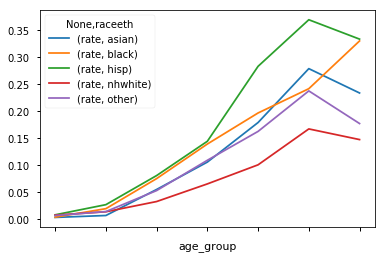

In [9]:
t = rasp_diabetes.reset_index().groupby(['raceeth','age_group']).sum()
t['rate'] = t.estimate/t.group_pop
t[['rate']].unstack(0).plot()

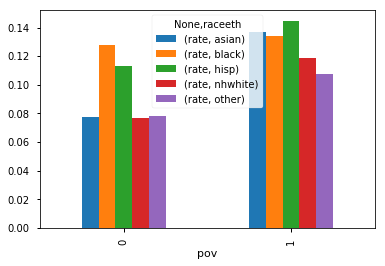

In [10]:
t = rasp_diabetes.reset_index().groupby(['raceeth','pov']).sum()
t['rate'] = t.estimate/t.group_pop
t[['rate']].unstack(0).plot(kind='bar')

# Compare to CHIS


Here is the AskCHIS page for:
* "Ever Diagnosed with diabetes"
* by OMB Race
* Pooling 2015, 2016 and 2017

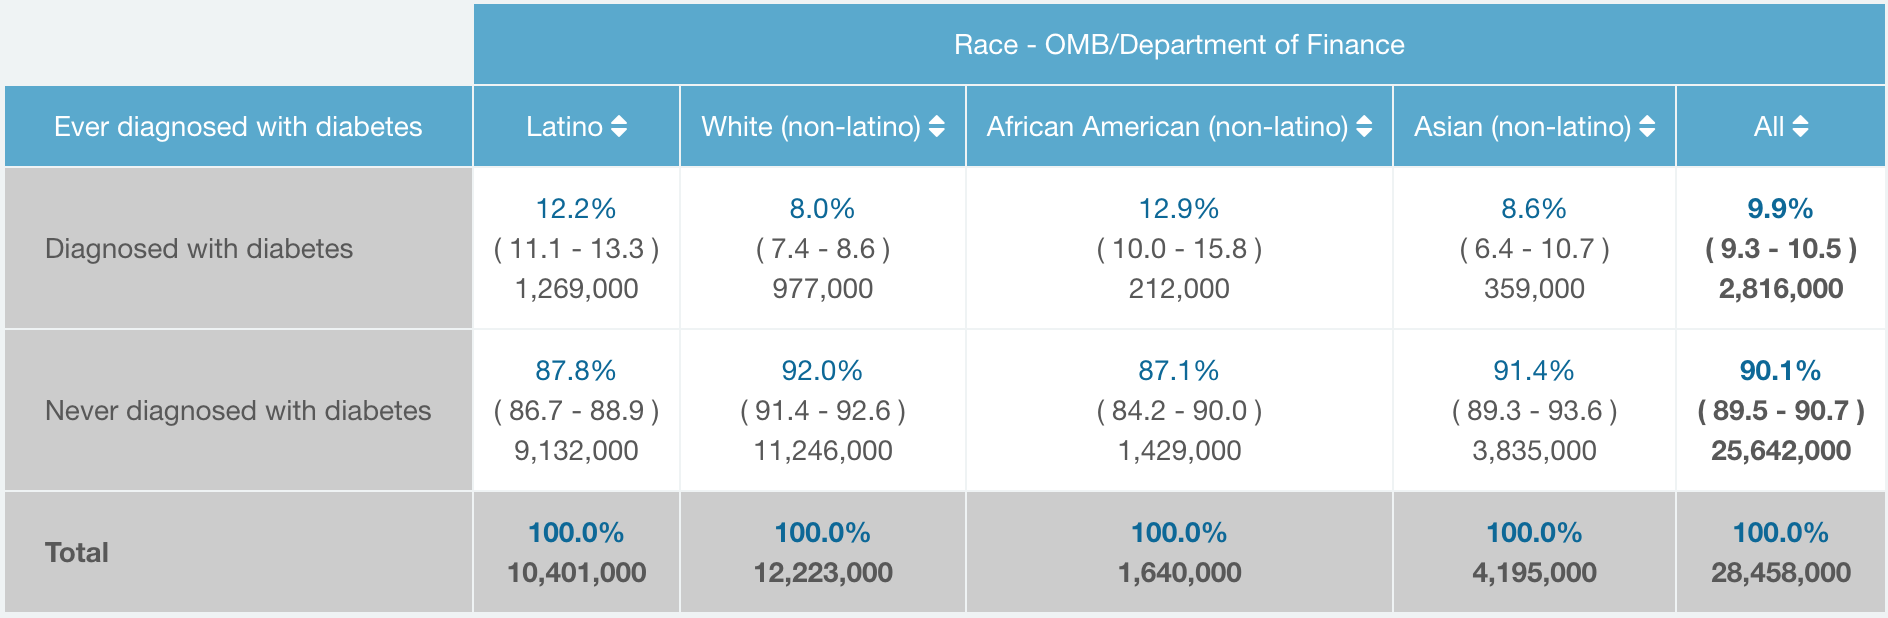

Below is the same values from this dataset, which agree very closely. Note that to get the same values, you must use the ``estimate`` column, not the ``imputed_estimate``.

In [11]:
t = rasp_diabetes.groupby('raceeth').sum().copy()
t['rate'] = (t.estimate / t.group_pop * 100).round(1)
t['rate']

raceeth
asian       8.6
black      12.9
hisp       12.2
nhwhite     8.0
other       8.3
Name: rate, dtype: float64

# AskCHIS, By Race, 55-64

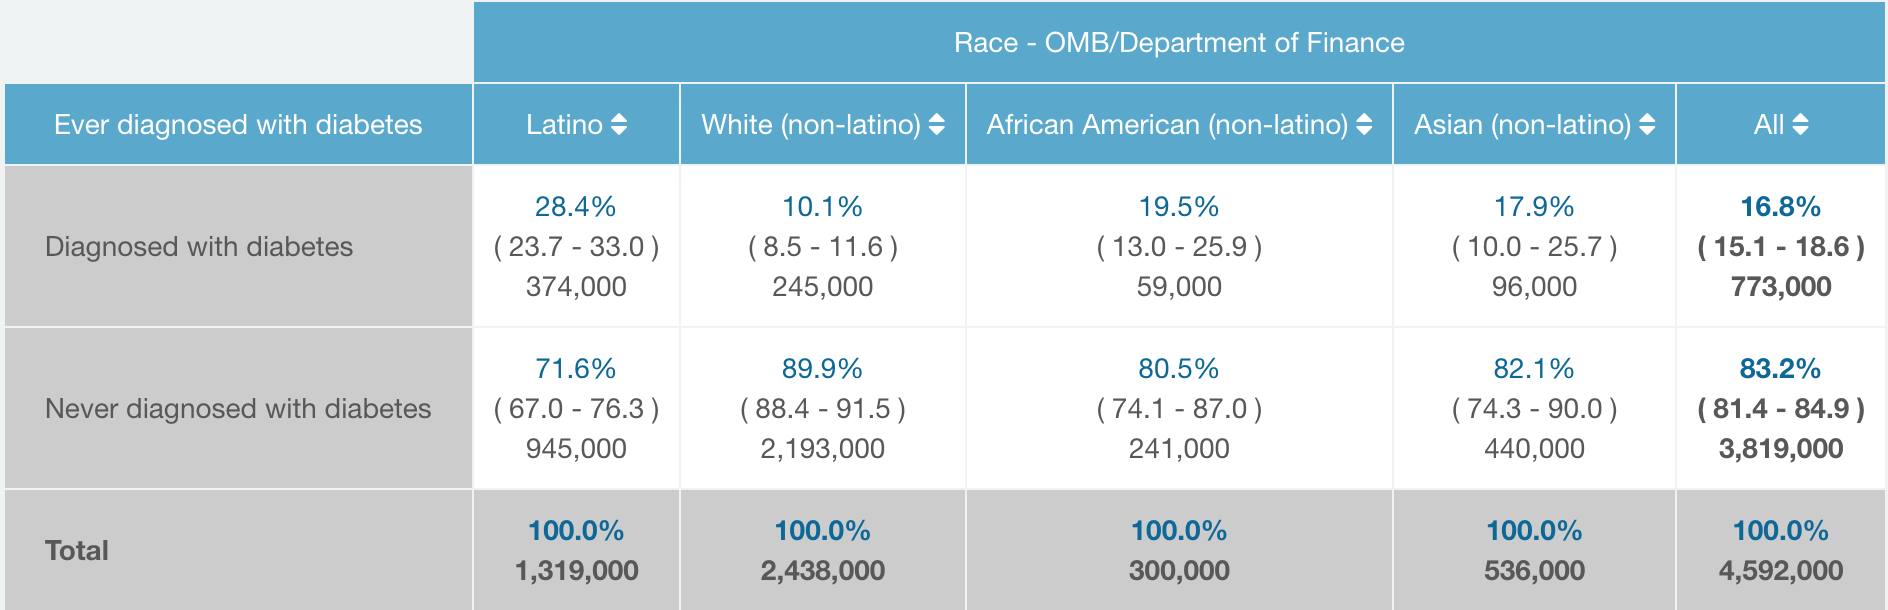


In [12]:
t = rasp_diabetes[ (rasp_diabetes.age_group=='55-064')  ].groupby('raceeth').sum().copy()
t['rate'] = (t.estimate / t.group_pop * 100).round(1)
assert round(t.loc['asian'].estimate,-3) == 96_000
t[['estimate','group_pop','rate']]

,estimate,group_pop,rate
raceeth,,,
asian,95941,536009,17.9
black,58940,299635,19.7
hisp,373566,1318747,28.3
nhwhite,244368,2431359,10.1
other,22386,137743,16.3


# AskCHIS, By Race, 55-64, Male

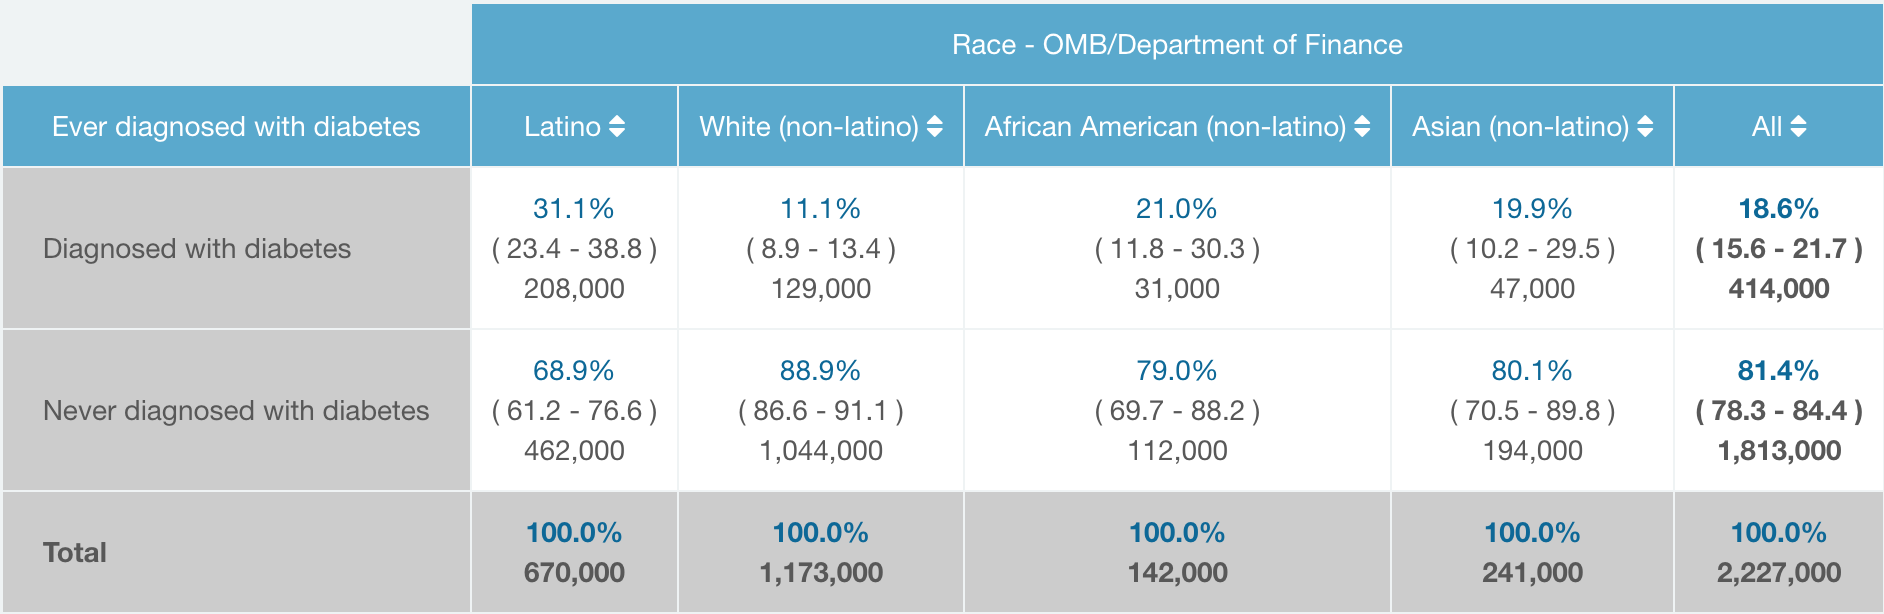


In [13]:
t = rasp_diabetes[ (rasp_diabetes.age_group=='55-064') & (rasp_diabetes.sex == 1) ].groupby('raceeth').sum().copy()
t['rate'] = (t.estimate / t.group_pop * 100).round(1)
assert round(t.loc['asian'].estimate,-3) == 47_000
t[['estimate','rate']]

,estimate,rate
raceeth,,
asian,46739,19.4
black,30508,21.4
hisp,207525,31.0
nhwhite,129023,11.0
other,8110,11.8


# AskChis, By Race, 55-64, In Poverty


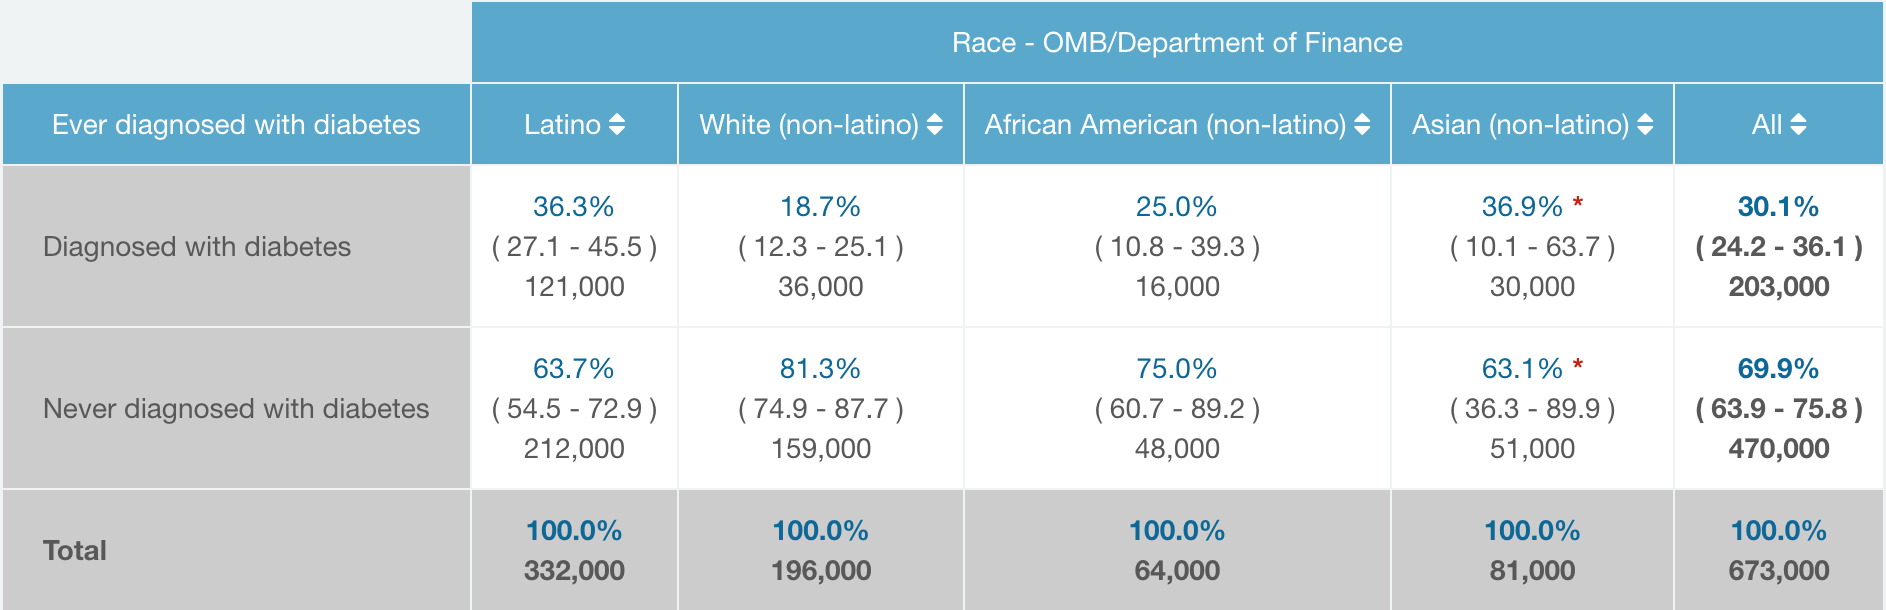


In [14]:
t = rasp_diabetes[ (rasp_diabetes.age_group=='55-064') & (rasp_diabetes.pov == 1) ].groupby('raceeth').sum().copy()
t['rate'] = (t.estimate / t.group_pop * 100).round(1)
assert round(t.loc['asian'].estimate,-3) == 30_000
t[['estimate','rate', 'group_pop']]

,estimate,rate,group_pop
raceeth,,,
asian,29679,36.7,80976
black,15868,24.8,63997
hisp,120816,36.4,332334
nhwhite,36447,18.6,195748
other,6666,24.9,26772
